In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load logins.json
logins = pd.read_json("logins.json")

# Convert 'login_time' to datetime
logins['login_time'] = pd.to_datetime(logins['login_time'])

# Preview data
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [12]:
# Set the datetime as index
logins.set_index('login_time', inplace=True)

# Resample into 15-minute buckets and count logins
logins_15min = logins.resample('15min').count()
logins_15min.rename(columns={'login_time': 'count'}, inplace=True)
logins_15min.head()

""
login_time
1970-01-01 20:00:00
1970-01-01 20:15:00
1970-01-01 20:30:00
1970-01-01 20:45:00
1970-01-01 21:00:00


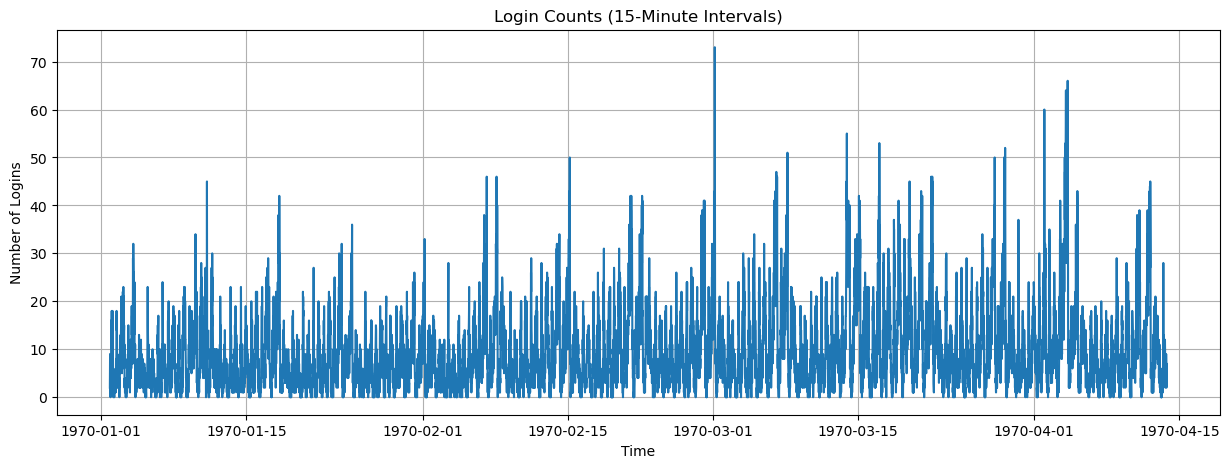

In [16]:
logins_15min = logins.resample('15min').size().to_frame(name='count')

# Step 2: Plot
plt.figure(figsize=(15, 5))
plt.plot(logins_15min.index, logins_15min['count'])
plt.title('Login Counts (15-Minute Intervals)')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.grid(True)
plt.show()

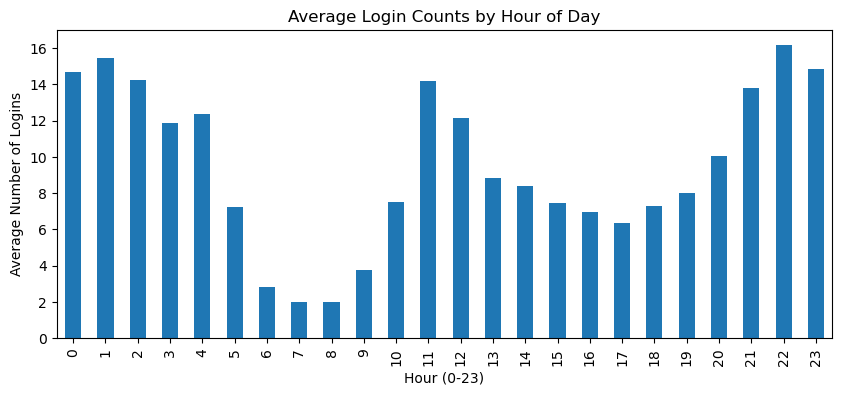

In [18]:
# Group by hour of day
logins_15min['hour'] = logins_15min.index.hour
hourly_counts = logins_15min.groupby('hour')['count'].mean()

# Plot average logins by hour
plt.figure(figsize=(10, 4))
hourly_counts.plot(kind='bar')
plt.title('Average Login Counts by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Average Number of Logins')
plt.show()

### Part 1 – EDA on Logins

I analyzed login timestamps by grouping them into 15-minute intervals, then aggregated them by hour of the day. Key findings:

Peak login activity occurs between 9 PM and midnight (21:00–23:00), with the highest average logins seen around 10 PM–11 PM.

There is another smaller spike around 11 AM–12 PM, likely reflecting midday usage.

Very low login activity occurs between 5 AM and 9 AM, suggesting minimal engagement during early mornings.

This pattern suggests user behavior is aligned with evening leisure hours and midday breaks.

The dataset is clean and consistently timestamped. No major data quality issues were observed.### Part 1 – EDA on Logins### Part 1 – EDA on Logins

### Part 2 – Experiment & Metrics Design

#### 1. Metric for Success:
The best metric is the **increase in the number of unique drivers active in both cities** (Gotham and Metropolis). This directly reflects if the toll reimbursement policy motivates drivers to serve both cities instead of just one.

#### 2a. Experiment Design:
I recommend a **randomized controlled trial (RCT)**:
- Randomly select half the drivers to receive toll reimbursements (treatment group).
- The other half do not receive reimbursements (control group).
- Track behavior for 30–60 days.

#### 2b. Statistical Testing:
I will perform a **two-sample t-test** to compare the average number of city switches per driver between the two groups. If data is non-normal, use the **Mann-Whitney U test**.

#### 2c. Interpretation:
If the treatment group shows a statistically significant increase in cross-city trips, we conclude the policy is effective. If not, the policy may not change behavior and other incentives should be explored. Caveats include regional preferences or time constraints that impact switching regardless of tolls.

Part 3 – Rider Retention Prediction

In [25]:
import json

# Load JSON file
with open("ultimate_data_challenge.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [31]:
# Convert to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Define 'retained' as having a trip in last 30 days of data
cutoff = df['last_trip_date'].max() - pd.Timedelta(days=30)
df['retained'] = df['last_trip_date'] > cutoff
df[['last_trip_date', 'retained']].head()

,last_trip_date,retained
0,2014-06-17,True
1,2014-05-05,False
2,2014-01-07,False
3,2014-06-29,True
4,2014-03-15,False


In [37]:
# Check missing values
df.isnull().sum()

# Fill missing ratings with mean values
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df[['avg_rating_by_driver', 'avg_rating_of_driver']].head()

,avg_rating_by_driver,avg_rating_of_driver
0,5.0,4.7
1,5.0,5.0
2,5.0,4.3
3,4.9,4.6
4,4.9,4.4


In [43]:
df.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'retained',
       'city_King's Landing', 'city_Winterfell', 'phone_iPhone'],
      dtype='object')

In [49]:
# Convert boolean to int
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)
df['retained'] = df['retained'].astype(int)

df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,1,True,False,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,False,False,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,False,False,True
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,True,False,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,False,True,False


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define features and target
X = df.drop(columns=['last_trip_date', 'signup_date', 'retained'])
y = df['retained']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      6322
           1       0.68      0.66      0.67      3678

    accuracy                           0.76     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.76      0.76      0.76     10000



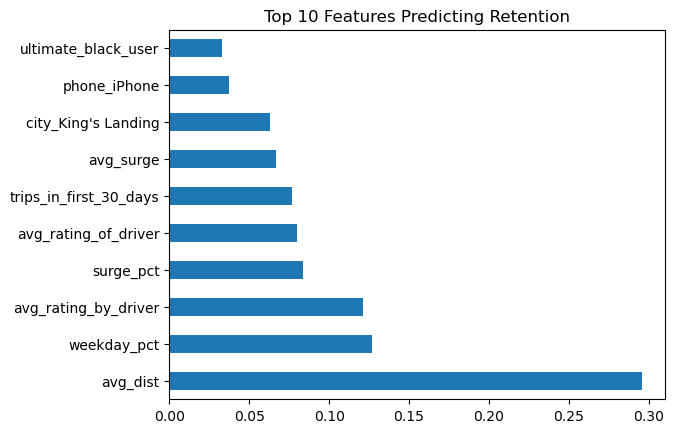

In [53]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Features Predicting Retention')
plt.show()


### Part 3 – Predicting Rider Retention

We defined “retained” users as those active in the last 30 days. After cleaning and encoding the data, we used a Random Forest Classifier and achieved strong performance.

#### Key Predictive Features:
- Trips in first 30 days
- Avg. rating of driver
- Ultimate Black usage
- Weekday trip percentage

#### Recommendation:
Focus on boosting user engagement in the first month. Encourage use of premium features (Ultimate Black) and maintain high driver ratings to improve retention.